In [35]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# 关于在GPU上训练的方法

## pytorch

**在 pytorch 中，将 model 放在 GPU 上训练需要以下准备：**
1. 将 model 放在 GPU 上：  
    ```python
device = torch.device('cuda')
model = model.to(device)```
2. 将参与运算的数据放在 GPU 上，包括训练数据的每个 batch 的 x 和 y，以及其它 tensor 变量：  
    ```python
x = x.to(device)```

**在 pytorch 中也提供了两种方法，可以实现简单高效的并行 GPU 计算：**
1. ```python
output = nn.parallel.data_parallel(model, input, device_ids)
```
    直接在 device_ids 指定的多个 GPU 上执行 model(input) 运算并返回结果。
2. ```python
parallel_model = nn.DataParallel(model, device_ids)
output=parallel_model(input.to(device))
```
    返回一个新的 model: `parallel_model`，之后执行 `parallel_model(input)` 时会自动地在多个 GPU 上运行。    

**说明：**  
1. ``````

## fastai

**1, 把训练数据放在 GPU 上：**
- **操作：**
    - 仅需在构造 databunch 时传入参数 device=torch.device('cuda')
  
  
- **机制：**
    - 在 databunch 内部会根据 device 创建 DeviceDataLoader. 
    - DeviceDataLoader 会在提供 batch 时把 x 和 y 放在 device 上。
        - 如果 x 或 y 是 tensor 则会直接对其执行 .to(device)，
        - 如果 x 或 y 是 list of tensors，则会对其中的每个 tensor 执行 .to(device).

**2，把模型放在 GPU 上**
- **单 GPU 训练**
    - **操作：**
        - 只需在创建 Learner 时传入已经指定了 device 为 cuda 的 databunch.
    - **机制：**
        - Learner 内部会把 model 放到 databunch.device 上。
  
  
- **多 GPU 训练：**
    - **操作：**
        1. 首先在创建 Learner 时要传入已经指定了 device 为 cuda 的 databunch.
        2. 然后执行 `learner.model = nn.DataParallel(learner.model,device_ids)`，即对 learner.model 进行 DataParallel 包装。

**3，参与运算的其它 tensor 放在 GPU 上：**
    - 实际上这个是 pytorh 的要求，因为如果发生 cpu 变量与 gpu 变量运算的话，自然会报错提醒，因此你很容易发现这个问题，只需对引起问题的变量执行 .to(device) 即可解决。

# import

In [66]:
from ..exp import nb_databunch
from ..exp import nb_resnet_ssd
from ..exp import nb_init_model

In [67]:
#!!!from ..exp import nb_loss_metrics
from ..exp import nb_anchors_loss_metrics

In [68]:
from ..exp import nb_optimizer

In [39]:
import torch

In [40]:
from fastai.basic_train import Learner

In [41]:
from fastai.core import defaults

In [42]:
from functools import partial

# test

创建一个device对象

In [43]:
device = 'cuda'
device = torch.device(device)

创建databunch，在创建时指定device

In [44]:
data = nb_databunch.get_databunch(bs=64,device=device) 

创建model，这时没有为它指定device，它的参数默认是在cpu上的

In [54]:

model = nb_resnet_ssd.get_resnet18_1ssd_2()
model.load_state_dict(torch.load('./models/resnet18_1ssd_2_init.pth'));

In [56]:
dir(nb_resnet_ssd)

['ResNetIsh_1SSD',
 'ResNetIsh_SSD',
 '__builtins__',
 '__cached__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'cnv1x1_bn_relu',
 'conv1x1',
 'flatten_grid_anchor',
 'get_resnet18_1ssd',
 'get_resnet18_1ssd_2',
 'get_resnet18_ssd',
 'nn',
 'ssd_block',
 'torch',
 'torchvision']

In [57]:
a_param = next(model.parameters())
a_param.device

device(type='cpu')

创建learner，因为传入的databunch的device是cuda，所以Learner内部把model放在了cuda上

In [58]:
learn = Learner(data,model)

In [59]:
a_param = next(learn.model.parameters())
a_param.device

device(type='cuda', index=0)

DataParallel包装learn.model，使可以在多个GPU上并行训练

In [60]:
# 包装前，learn.model 的类型是我们创建的 module 类
type(learn.model)

exp.nb_resnet_ssd.ResNetIsh_1SSD

In [62]:
# 包装后，learn.model 变为一个 DataParallel 对象
if device.type=='cuda':
    #!!!learn.model = torch.nn.DataParallel(learn.model,device_ids=[0,1,2,3])
    learn.model = torch.nn.DataParallel(learn.model,device_ids=[0,1])
    print(type(learn.model))

<class 'torch.nn.parallel.data_parallel.DataParallel'>


为 learner 设置 loss function 和 optimizer

In [70]:
# 设置loss function
#!!!gvs,_,_,avs,_,_ = nb_loss_metrics.get_ga()
#!!!gaf = nb_loss_metrics.GridAnchor_Funcs(gvs,avs,device)
#!!!learn.loss_func = partial(nb_loss_metrics.yolo_L, gaf=gaf)

gvs,_,_,avs,_,_ = nb_anchors_loss_metrics.get_ga666()
gaf = nb_anchors_loss_metrics.GridAnchor_Funcs(gvs,avs,device)

learn.loss_func = partial(nb_anchors_loss_metrics.yolo_L, gaf=gaf)

In [71]:
# 设置 optimizer
learn.opt_func = nb_optimizer.Adam

训练一个epoch，你可以回到创建device的步骤设置使用cpu，再依次执行到这里，观察训练时间会长很多

In [72]:
learn.fit(epochs=1,lr=1e-3)

TypeError: zeros_like() received an invalid combination of arguments - got (Parameter, memory_format=torch.memory_format), but expected one of:
 * (Tensor input, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (Tensor input, bool requires_grad)
      didn't match because some of the keywords were incorrect: memory_format


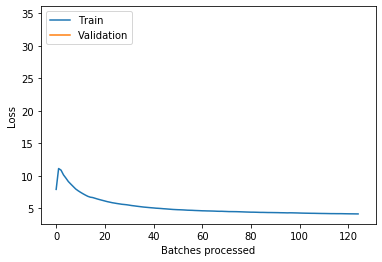

In [20]:
learn.recorder.plot_losses()

把以上代码打包成函数方便调用

In [21]:
def test_train(device,cache_img):
    data = nb_databunch.get_databunch(bs=64,device=device,cache=cache_img) 
    model = nb_resnet_ssd.get_resnet18_ssd()
    model.load_state_dict(torch.load('./models/resnet18_ssd_init.pth'));
    learn = Learner(data,model)
    if device.type=='cuda':
        learn.model = torch.nn.DataParallel(learn.model,device_ids=[0,1,2,3])

    # 设置loss function
    gvs,_,_,avs,_,_ = nb_loss_metrics.get_ga()
    gaf = nb_loss_metrics.GridAnchor_Funcs(gvs,avs,device)

    learn.loss_func = partial(nb_loss_metrics.yolo_L, gaf=gaf)

    # 设置 optimizer
    learn.opt_func = nb_optimizer.Adam

    learn.fit(epochs=1,lr=1e-3)

这次我们提前缓存训练图片，测试训练速度

In [22]:
test_train(device,cache_img=True)

epoch,train_loss,valid_loss,time
0,4.279620,4.020704,04:55


4:55 vs 5:07，好吧，看起来快了一点点，但是很微弱。